In [ ]:
# pip install -r requirements.txt

# Feature Selection

A etapa de seleção de características (feature selection) é um processo crítico no desenvolvimento de modelos de Machine Learning. Sua importância pode ser destacada em vários aspectos: <br>

- Melhoria do Desempenho do Modelo <br>
- Redução de Overfitting <br>
- Redução do Tempo de Treinamento <br>
- Interpretabilidade e Explicabilidade <br>
- Gerenciamento de Recursos <br>
- Identificação de Características Importantes <br>

Existem inúmeras técnicas de feature selection algumas já são conhecidas de muito tempo (teste de qui-quadrado) e outras foram sendo desenvolvidas a medida que a computação avançou (RFE, Shap). <br>

Após os insights obtidos na etapa de análise exploratória vamos selecionar algumas informações disponiveis. Para o dado ser selecionado ele precisava responder uma pergunta:<br>

O dado ou a informação obtida com aquela coluna antecede o evento que define se o voo esta pontual ou atrasado?<br>

Por exemplo as colunas, partida_real, chegada_real, delta_tempo e outras são informações resultantes do voo estar atrasado ou pontual <br>

Outro destaque importante a ser considerado é que a variavel utilizada para predizer (status_do_voo) ela esta desbalanceada. Nesse primeiro momento não vamos fazer nada, porém na etapa de treinamento sim. <br>

Um artigo que aborda algumas alternativas que vão ser utilizadas aqui:<br>
https://medium.com/data-hackers/como-selecionar-as-melhores-features-para-seu-modelo-de-machine-learning-faf74e357913<br>

# Pacotes

In [2]:
# Bibliotecas padrão e de manipulação de dados
from datetime import date
import pandas as pd
import numpy as np
from pytz import timezone
import os 
import warnings

# Visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Machine Learning - Modelos
import xgboost as xgb
from xgboost import plot_importance
from xgboost import plot_tree
import catboost as ctb
from catboost import Pool
from sklearn.tree import DecisionTreeClassifier
import graphviz

# Machine Learning - Pré-processamento, Seleção e Métricas
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, KFold
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Configurações e Ferramentas Auxiliares
import sklearn
import shap
import ppscore as pps

# Ignorar avisos e configurações de exibição
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

# Impressão de versões
print(xgb.__version__)
print(sklearn.__version__)


2.0.2
1.2.0


In [3]:
pip freeze > requirements_feature_selection.txt

Note: you may need to restart the kernel to use updated packages.


# Funções

In [1]:
def recursive_feature_eng(model, X, Y):
    """
    Realiza Engenharia de Recursos Recursiva para um modelo de aprendizado de máquina.

    Args:
    model: Modelo de aprendizado de máquina para o qual a engenharia de recursos será aplicada.
    X: DataFrame ou matriz de características/features.
    Y: DataFrame, série ou matriz de rótulos/respostas.

    Processo:
    1. Inicia a engenharia de recursos recursiva usando o modelo fornecido.
    2. Aplica o ajuste (fit) do RFE (Recursive Feature Elimination) no conjunto de dados.
    3. Imprime o número de recursos selecionados, os recursos escolhidos e a classificação da importância dos recursos.
    4. Finaliza a engenharia de recursos recursiva.

    Returns:
    list: Uma lista contendo o ajuste RFE, o número de recursos selecionados e um array booleano dos recursos escolhidos.
    """
    print("[INFO] Starting Recursive Feature Engineering")
    rfe = RFE(model)
    rfe_fit = rfe.fit(X,Y)
    print("Number of features chosen: %d" % rfe_fit.n_features_)
    print("Selected features chosen: %s" % rfe_fit.support_)
    print("Fit ranking of feature importance: %s" % rfe_fit.ranking_)
    print("[INFO] Ending Recursive Feature Engineering")
    return [rfe_fit, rfe_fit.n_features_, rfe_fit.support_]



def categorics_type(df, list_categorics):
    """
    Converte colunas especificadas de um DataFrame para o tipo 'category'.

    Args:
    df (pd.DataFrame): DataFrame a ser modificado.
    list_categorics (list): Lista de nomes de colunas a serem convertidas para o tipo 'category'.

    Processo:
    1. Itera sobre a lista de colunas especificadas.
    2. Converte cada coluna na lista para o tipo 'category'.
    3. Retorna o DataFrame modificado.

    Returns:
    pd.DataFrame: DataFrame com as colunas especificadas convertidas para o tipo 'category'.
    """
    for i in list_categorics:
        df[i] = df[i].astype("category")
    return df

# Dados

In [3]:
file_path = 'dados_tratados/historico_voo_tratados.csv'
df = pd.read_csv(file_path)

In [4]:
# Tratamento de NA nas colunas de UF
df['uf_origem'] = df['uf_origem'].fillna('EXTRANGEIRO')
df['uf_destino'] = df['uf_destino'].fillna('EXTRANGEIRO')



# Mapeamento para dias da semana e meses
mapeamento_dias = {0: 'Segunda-feira', 1: 'Terça-feira', 2: 'Quarta-feira', 3: 'Quinta-feira', 4: 'Sexta-feira', 5: 'Sábado', 6: 'Domingo'}
mapeamento_meses = {
    1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril', 5: 'Maio', 6: 'Junho',
    7: 'Julho', 8: 'Agosto', 9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'}

# Aplicando os mapeamentos
df['dia_semana_partida'] = df['dia_semana_partida'].map(mapeamento_dias)
df['dia_semana_chegada'] = df['dia_semana_chegada'].map(mapeamento_dias)
df['mes_partida'] = df['mes_partida'].map(mapeamento_meses)
df['mes_chegada'] = df['mes_chegada'].map(mapeamento_meses)

# O restante foi tratado como sem informação (SI)
df= df.fillna('SI')

In [5]:
# Definir o caminho do diretório e do arquivo CSV
diretorio = 'dados_tratados'
nome_arquivo = 'historico_voo_tratados_train.csv'
caminho_completo = os.path.join(diretorio, nome_arquivo)
df.to_csv(caminho_completo, index=False)

# Treino para utilização de algoritimos como ferramentade feature selection

Para aplicação de algumas técnicas de feature selection será necessário fazer um treinamento de modelo. Estão sendo utilizadas duas bibliotecas (XGboost e Catboost), estas foram escolhidas por possuirem beneficios diferentes. Por exmeplo<br>

- Com Catboost temos uma aplicação mais simplificada do RFE<br>
- O Catboost permite treinar o modelo sem fazer o one hot encoding, isso permite analisar as variaveis categoricas de forma agrupada<br>
- O XGboost tem uma aplicação mais efetetiva do Select From Model<br>
- O XGboost permite uma análise mais profunda quando utilizamos o RFE<br>

Por fim são modelos de árvore com otimizações realizadas via algoritmo Gradient Boosting Machines (GBM), ou seja, são bons algoritmos informam a importâncias das features que compõe o modelo. 

## Pre-treino para feature selection

In [6]:
# Seleção de colunas que vai participar do processo.
df_feature = df[['nome_empresas','codigo_tipo_linha','descricao_origem','descricao_destino','pais_origem','pais_destino','continente_origem',
                 'continente_destino','cidade_origem','cidade_destino','uf_origem','uf_destino','mes_partida','mes_chegada',
                 'dia_semana_partida','dia_semana_chegada','status_do_voo']]

# Seleção das features(variaveis) preditoras
dt_ax = df_feature.drop(columns = ['status_do_voo'])

# Seleção da variavel a ser predita a probabilidade
dt_ay = df_feature[['status_do_voo']].copy()

label_encoder = LabelEncoder()
dt_ay = label_encoder.fit_transform(dt_ay)

list_dummies = ['nome_empresas','codigo_tipo_linha','descricao_origem','descricao_destino','pais_origem','pais_destino','continente_origem',
                 'continente_destino','cidade_origem','cidade_destino','uf_origem','uf_destino','mes_partida','mes_chegada',
                 'dia_semana_partida','dia_semana_chegada']

dt_ax_dummies = pd.get_dummies(dt_ax, columns=list_dummies, dummy_na=True)

# Segmentação em Treino (75%) e Teste (25%)
X_train_hot, X_test_hot, y_train_hot, y_test_hot = train_test_split(dt_ax_dummies, dt_ay, random_state=42, test_size=0.25)

# Segmentação em Treino (75%) e Teste (25%)
X_train, X_test, y_train, y_test = train_test_split(dt_ax, dt_ay, random_state=42, test_size=0.25)

## Treino

### XGBoost

In [7]:
model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_train_hot,y_train_hot)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### CatBoost

In [30]:
cat_features =  list(dt_ax.select_dtypes(include=['object']))
train_pool = Pool(X_train, y_train, cat_features)
test_pool = Pool(X_test, y_test, cat_features)

model_ctb_pool = ctb.CatBoostClassifier(iterations=5,verbose=False)

model_ctb_pool.fit(train_pool, eval_set=test_pool, verbose=False)
print(model_ctb_pool)

print('CatBoost model is fitted: ' + str(model_ctb_pool.is_fitted()))
print('CatBoost model parameters:')
print(model_ctb_pool.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 5, 'verbose': False}


In [31]:
cat_features =  list(dt_ax.select_dtypes(include=['object']))

model_ctb = ctb.CatBoostClassifier( cat_features = cat_features)
model_ctb.fit(dt_ax, dt_ay, cat_features=cat_features, verbose=False)

print('CatBoost model is fitted: ' + str(model_ctb.is_fitted()))

CatBoost model is fitted: True


In [32]:
model_ctb_hot = ctb.CatBoostClassifier(iterations=5,verbose=False)

model_ctb_hot.fit(X_train_hot, y_train_hot,  verbose=False) #cat_features=cat_features,
print(model_ctb_hot)

print('CatBoost model is fitted: ' + str(model_ctb_hot.is_fitted()))
print('CatBoost model parameters:')
print(model_ctb_hot.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 5, 'verbose': False}


# Teste de chi-quadrado

Teste de chi-quadrado: <br>

- Utilizado principalmente para dados categóricos.<br>

- Testa a independência entre duas variáveis categóricas.<br>

- No teste de qui-quadrado, você cria uma tabela de contingência que resume a frequência de cada combinação de categorias entre duas variáveis e calcula o valor de qui-quadrado para testar se há uma relação significativa entre elas. <br>

- O resultado indica se as distribuições de frequência das categorias em uma variável diferem entre as categorias da outra variável.<br>

In [39]:
from scipy.stats import chi2_contingency
import numpy as np

# Lista de variáveis preditoras
preditoras = ['nome_empresas', 'codigo_tipo_linha', 'descricao_origem', 'descricao_destino', 
              'pais_origem', 'pais_destino', 'continente_origem', 'continente_destino', 
              'cidade_origem', 'cidade_destino', 'uf_origem', 'uf_destino', 
              'mes_partida', 'mes_chegada', 'dia_semana_partida', 'dia_semana_chegada']

# Resultados do teste de qui-quadrado
resultados_chi2 = {}

for coluna in preditoras:
    tabela_contingencia = pd.crosstab(df[coluna], df['status_do_voo'])
    chi2, p, dof, expected = chi2_contingency(tabela_contingencia)
    resultados_chi2[coluna] = p

resultados_chi2

{'nome_empresas': 0.0,
 'codigo_tipo_linha': 0.0,
 'descricao_origem': 0.0,
 'descricao_destino': 0.0,
 'pais_origem': 1.4891115186198422e-267,
 'pais_destino': 3.842749216774587e-91,
 'continente_origem': 1.488445022642144e-95,
 'continente_destino': 1.1258870508844929e-61,
 'cidade_origem': 0.0,
 'cidade_destino': 0.0,
 'uf_origem': 0.0,
 'uf_destino': 1.5619852904363998e-157,
 'mes_partida': 0.0,
 'mes_chegada': 0.0,
 'dia_semana_partida': 0.0,
 'dia_semana_chegada': 0.0}

Análise:<br> 

Valores p iguais a 0.0: para a maioria das variáveis preditoras (como 'nome_empresas', 'codigo_tipo_linha', 'descricao_origem', 'descricao_destino', entre outras), o valor p é 0.0. Isso indica que a associação entre estas variáveis e o 'status_do_voo' é extremamente forte e estatisticamente significativa. Em outras palavras, há evidências de que essas variáveis têm um impacto significativo no status do voo.<br> 
<br> 
Valores p muito pequenos, mas não zero: para variáveis como 'pais_origem', 'pais_destino', 'continente_origem', 'continente_destino', 'uf_destino', os valores p são extremamente pequenos (próximos de zero, mas não zero), o que também indica uma associação estatisticamente significativa entre estas variáveis e o 'status_do_voo'. Estes valores sugerem que, embora a influência dessas variáveis possa não ser tão forte quanto as outras com valor p exato de zero, ainda assim elas têm um impacto relevante.

<br> 
Na prática, um valor p muito baixo (próximo ou igual a zero) em um teste de qui-quadrado indica que há uma diferença significativa entre os grupos comparados. Para este conjunto de dados, significa que as variáveis preditoras têm uma relação significativa com o status do voo.<br>

| Variável            | Valor p                       |
|---------------------|-------------------------------|
| nome_empresas       | 0.0                           |
| codigo_tipo_linha   | 0.0                           |
| descricao_origem    | 0.0                           |
| descricao_destino   | 0.0                           |
| pais_origem         | 1.4891115186198422e-267       |
| pais_destino        | 3.842749216774587e-91         |
| continente_origem   | 1.488445022642144e-95         |
| continente_destino  | 1.1258870508844929e-61        |
| cidade_origem       | 0.0                           |
| cidade_destino      | 0.0                           |
| uf_origem           | 0.0                           |
| uf_destino          | 1.5619852904363998e-157       |
| mes_partida         | 0.0                           |
| mes_chegada         | 0.0                           |
| dia_semana_partida  | 0.0                           |
| dia_semana_chegada  | 0.0                           |


# Recursive Feature Elimination (RFE)

Recursive Feature Elimination, também conhecido como Métodos de Eliminação Recursiva de Características.  Utiliza modelos como máquinas de vetores de suporte (SVM) para eliminar iterativamente as características menos importantes.<br>

Como Funciona?<br>

- Treinamento Inicial: RFE começa treinando um modelo inicial usando todas as características disponíveis. Este modelo deve ser capaz de fornecer alguma forma de ranking de importância para cada  característica, como coeficientes em modelos lineares ou importâncias de características em árvores de decisão.<br>

- Eliminação Recursiva: Em cada etapa, RFE elimina a característica (ou características) menos importante(s) com base no ranking fornecido pelo modelo. Após a remoção, o modelo é re-treinado com o conjunto reduzido de características.<br>

- Processo Iterativo: Este processo é repetido até que o número desejado de características seja alcançado.<br>

Interpretação

- Importância das Características: RFE ajuda a identificar quais características são mais significativas para o modelo. As características selecionadas são aquelas que o modelo considera mais relevantes para a previsão.<br>

- Desempenho do Modelo: Ao eliminar características irrelevantes ou redundantes, o RFE pode melhorar o desempenho do modelo, reduzir o risco de overfitting e aumentar a interpretabilidade.<br>

- Balanceamento: É importante encontrar um equilíbrio entre reduzir o número de características e manter a precisão do modelo. Demasiada eliminação pode levar à perda de informações cruciais.<br>

Apessar dessa técnica ter algumas semelhanças com a stepwise, ela é uma técnica diferente.

## RFE no XGBoost

In [29]:
rfe_fit =  recursive_feature_eng(model_xgb, X_train_hot, y_train_hot)
columns_to_remove = rfe_fit[2]
X_reduced = X_train_hot.loc[:,columns_to_remove]
list(X_reduced)

[INFO] Starting Recursive Feature Engineering
Number of features chosen: 420
Selected features chosen: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  T

['nome_empresas_AZUL',
 'nome_empresas_GOL',
 'nome_empresas_TAM',
 'nome_empresas_nan',
 'codigo_tipo_linha_C',
 'codigo_tipo_linha_E',
 'codigo_tipo_linha_G',
 'codigo_tipo_linha_H',
 'codigo_tipo_linha_I',
 'codigo_tipo_linha_L',
 'codigo_tipo_linha_N',
 'codigo_tipo_linha_R',
 'codigo_tipo_linha_nan',
 'descricao_origem_AB DHABI INTERNATIONAL',
 'descricao_origem_ADALBERTO MENDES DA SILVA',
 'descricao_origem_ADOLFO SUÃ\x81REZ MADRID-BARAJAS AIRPORT',
 'descricao_origem_AEROPORTO INTERNACIONAL AMÃ\x8dLCAR CABRAL',
 'descricao_origem_AEROPORTO INTERNACIONAL DO RIO DE JANEIRO/GALEÃO – ANTONIO CARLOS JOBIM',
 'descricao_origem_AEROPORTO MUNCIPAL DE DOURADOS',
 'descricao_origem_AEROPORTO REGIONAL PLÍNIO ALARCON',
 'descricao_origem_AFONSO PENA',
 'descricao_origem_ALTAMIRA',
 'descricao_origem_ATLAS BRASIL CANTANHEDE',
 'descricao_origem_BAHIA - JORGE AMADO',
 'descricao_origem_BARCELONA-EL PRAT AIRPORT',
 'descricao_origem_BARRA DO GARÇAS',
 'descricao_origem_BARREIRAS',
 'descricao_

Análise:<br>

O RFE identificou 420 características como sendo as mais importantes para o modelo, partindo inicialmente de um total de 841 variáveis. Esse número elevado se deve ao fato de que o modelo passou pelo processo de one hot encoding. Este processo transforma colunas categóricas, como 'UF' que possui 27 categorias distintas, em múltiplas colunas com valores binários 0 ou 1. Considerando que todas as colunas utilizadas no modelo eram categóricas, a alta dimensionalidade resultante é compreensível e esperada.<br>

Outro ponto é que diversas colunas foram classificadas com a mesma posição de importância máxima no ranking, ilustrando o impacto significativo que essas variáveis têm no modelo. É importante destacar que não é possível determinar os estados mais influentes isoladamente, pois todos contribuem para a performance do modelo durante o treinamento. Isso ocorre porque, apesar de algumas unidades federativas se destacarem, os voos para outras regiões também continuam existindo e desempenham um papel na modelagem dos dados. Portanto, a análise deve considerar o conjunto total de estados ao invés de focar em unidades específicas.<br>

## RFE no CatBoost

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

The number of features selection steps (2) is greater than the number of features to eliminate (1). The number of steps was reduced to 1.


Learning rate set to 0.176863
Step #1 out of 1
0:	learn: 0.5854434	total: 173ms	remaining: 2m 52s
1:	learn: 0.5187274	total: 278ms	remaining: 2m 18s
2:	learn: 0.4758019	total: 446ms	remaining: 2m 28s
3:	learn: 0.4485366	total: 524ms	remaining: 2m 10s
4:	learn: 0.4250469	total: 973ms	remaining: 3m 13s
5:	learn: 0.4092930	total: 1.36s	remaining: 3m 45s
6:	learn: 0.4002104	total: 1.72s	remaining: 4m 4s
7:	learn: 0.3928792	total: 2.17s	remaining: 4m 29s
8:	learn: 0.3879180	total: 2.6s	remaining: 4m 46s
9:	learn: 0.3848889	total: 2.99s	remaining: 4m 55s
10:	learn: 0.3825513	total: 3.41s	remaining: 5m 6s
11:	learn: 0.3813084	total: 3.82s	remaining: 5m 14s
12:	learn: 0.3804072	total: 4.28s	remaining: 5m 24s
13:	learn: 0.3794059	total: 4.71s	remaining: 5m 31s
14:	learn: 0.3787147	total: 5.08s	remaining: 5m 33s
15:	learn: 0.3779949	total: 5.5s	remaining: 5m 38s
16:	learn: 0.3771406	total: 5.98s	remaining: 5m 45s
17:	learn: 0.3769530	total: 6.41s	remaining: 5m 49s
18:	learn: 0.3765356	total: 6.8

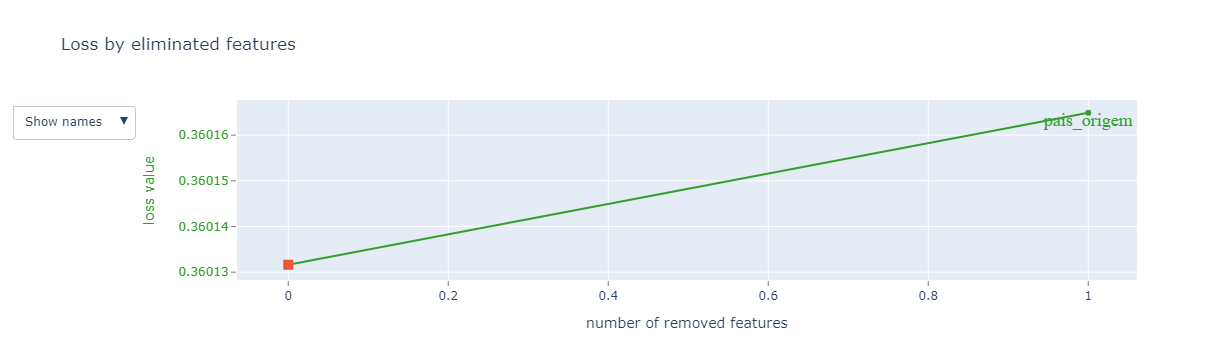

In [33]:
rfe_dict = model_ctb.select_features(X = dt_ax, 
                                     y = dt_ay, 
                                     features_for_select = '0-15',
                                     num_features_to_select = 15,
                                     steps = 2,
                                     train_final_model = False,
                                     plot = True)

# Select From Model (SFM)

Como Funciona?

- Definição de um Limiar: O método começa com a definição de um limiar que determina quais características serão selecionadas. Esse limiar pode ser um valor definido manualmente, um percentual das características mais importantes, ou pode ser derivado de algum critério estatístico.<br>

- Importâncias das Características: O modelo (por exemplo, XGBoost) fornece um ranking ou pontuação de importância para cada característica com base no treinamento realizado.<br>

- Seleção de Características: Com base no limiar definido, o método seleciona as características cuja importância está acima desse limiar.<br>

- Retreinamento do Modelo: Após a seleção das características, um novo modelo é treinado apenas com as características selecionadas. Este processo pode ser repetido com diferentes limiares para encontrar o melhor conjunto de características para o modelo.<br>

Assim como RFE é um processo iterativo onde é feito um retreino após a seleção e isso pode ser feita inúmeras vezes como mencionado. Logo é uma estratégia um pouco custosa a nível de processamento. <br>

## XGboost

In [20]:
# Supõe-se que model_xgb já esteja definido e treinado
model_xgb_SFM = model_xgb

# Realiza previsões para o conjunto de teste e avalia
predictions = model_xgb_SFM.predict(X_test_hot)
accuracy = accuracy_score(y_test_hot, predictions)
print("Acurácia: %.2f%%" % (accuracy * 100.0))

# Ajusta o modelo usando cada importância como um limiar
thresholds = np.sort(model_xgb_SFM.feature_importances_)

for thresh in thresholds:
    # Seleciona características usando o limiar
    selection = SelectFromModel(model_xgb_SFM, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train_hot)

    # Treina o modelo
    selection_model = xgb.XGBClassifier(verbose=False)
    selection_model.fit(select_X_train, y_train_hot)

    # Avalia o modelo
    select_X_test = selection.transform(X_test_hot)
    predictions = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_test_hot, predictions)
    print("Limiar=%.3f, n=%d, Acurácia: %.2f%%" % (thresh, select_X_train.shape[1], accuracy * 100.0))

Accuracy: 86.51%
Thresh=0.000, n=841, Accuracy: 86.51%
Thresh=0.000, n=841, Accuracy: 86.51%
Thresh=0.000, n=841, Accuracy: 86.51%
Thresh=0.000, n=841, Accuracy: 86.51%
Thresh=0.000, n=841, Accuracy: 86.51%
Thresh=0.000, n=841, Accuracy: 86.51%
Thresh=0.000, n=841, Accuracy: 86.51%
Thresh=0.000, n=841, Accuracy: 86.51%
Thresh=0.000, n=841, Accuracy: 86.51%
Thresh=0.000, n=841, Accuracy: 86.51%
Thresh=0.000, n=841, Accuracy: 86.51%
Thresh=0.000, n=841, Accuracy: 86.51%
Thresh=0.000, n=841, Accuracy: 86.51%
Thresh=0.000, n=841, Accuracy: 86.51%
Thresh=0.000, n=841, Accuracy: 86.51%
Thresh=0.000, n=841, Accuracy: 86.51%
Thresh=0.000, n=841, Accuracy: 86.51%
Thresh=0.000, n=841, Accuracy: 86.51%
Thresh=0.000, n=841, Accuracy: 86.51%
Thresh=0.000, n=841, Accuracy: 86.51%
Thresh=0.000, n=841, Accuracy: 86.51%
Thresh=0.000, n=841, Accuracy: 86.51%
Thresh=0.000, n=841, Accuracy: 86.51%
Thresh=0.000, n=841, Accuracy: 86.51%
Thresh=0.000, n=841, Accuracy: 86.51%
Thresh=0.000, n=841, Accuracy: 86

Análise:<br>

A Acurácia ficou consistente,  isso para a maioria dos limiares, o que indica que muitas das características eliminadas não estavam contribuindo significativamente para a acurácia do modelo.Logo muitas das características eliminadas não estavam contribuindo significativamente para a acurácia do modelo.<br>

Aqui temos um sinal que talvez tenha um grupo de informações que predomina a predição<br>

# Feature Importance

Como foi dito anteriormente o XGBoost e o CatBoost são dois algoritmos de ávore e possuem boosting e oferecem suporte para a avaliação da importância. Essa funcionalidade é extremamente útil para entender quais características estão contribuindo mais para as previsões do modelo.<br>

O XGboost conta com alguma medidas para avaliar<br>

- Feature Weight (Peso da Característica): Conta o número de vezes que uma característica aparece em todas as árvores do modelo.<br>

- Gain (Ganho): Mede a contribuição média de uma característica para a melhoria do modelo. É a melhoria média nos splits que usam a característica.<br>

- Cover (Cobertura): Refere-se ao número médio de amostras afetadas por splits sobre a característica.<br>

## XGBoost

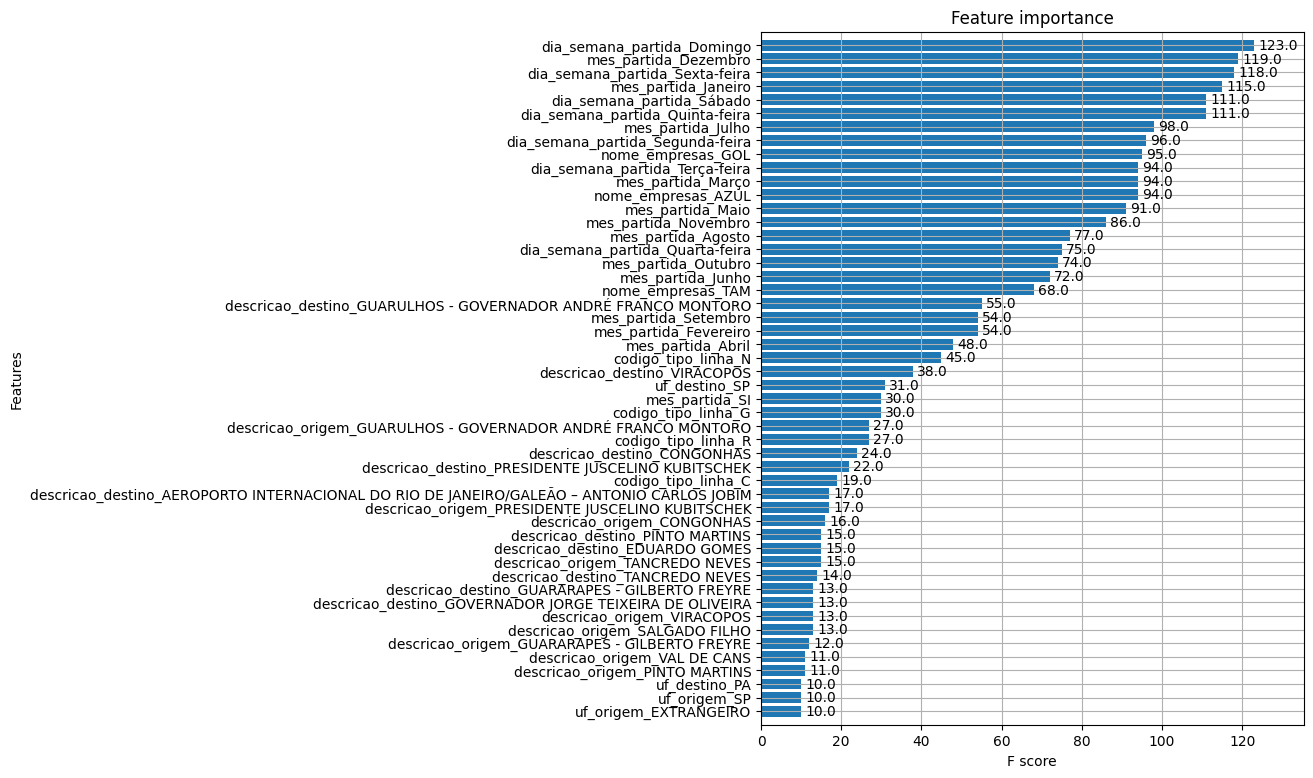

In [32]:
fig, ax = plt.subplots(figsize=(7,9))
xgb.plot_importance(model_xgb, max_num_features=50, height=0.8, ax=ax)
plt.show()

### Treeplot XGBOOST

O XGBoost nos permite visualizar a árvore de decisão para compreender melhor o caminho seguido por ele. <br>

Sobre o algoritmo:<br>
https://www.youtube.com/watch?v=OtD8wVaFm6E (Parte 1)<br>
https://www.youtube.com/watch?v=8b1JEDvenQU (Parte 2)<br>


<Figure size 5000x5000 with 0 Axes>

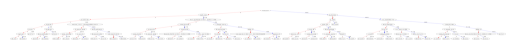

In [26]:
# plot single tree
#fig, ax = plt.subplots(figsize=(100, 100))
#fig = plt.figure(figsize=(12, 6))
plt.figure(figsize=(50, 50))
plot_tree(model_xgb)
plt.savefig('xgb_treeplot.jpg', dpi=1800)  
plt.show()

## CatBoost

Diferentemente do XGBoost, o CatBoost não passou por one hot encoding, logo as informações agrupadas nos permite compreender melhor o peso de cada categoria. Algo que até o momento só o teste de qui-quadrado permitiu

Text(0.5, 1.0, 'Feature Importance')

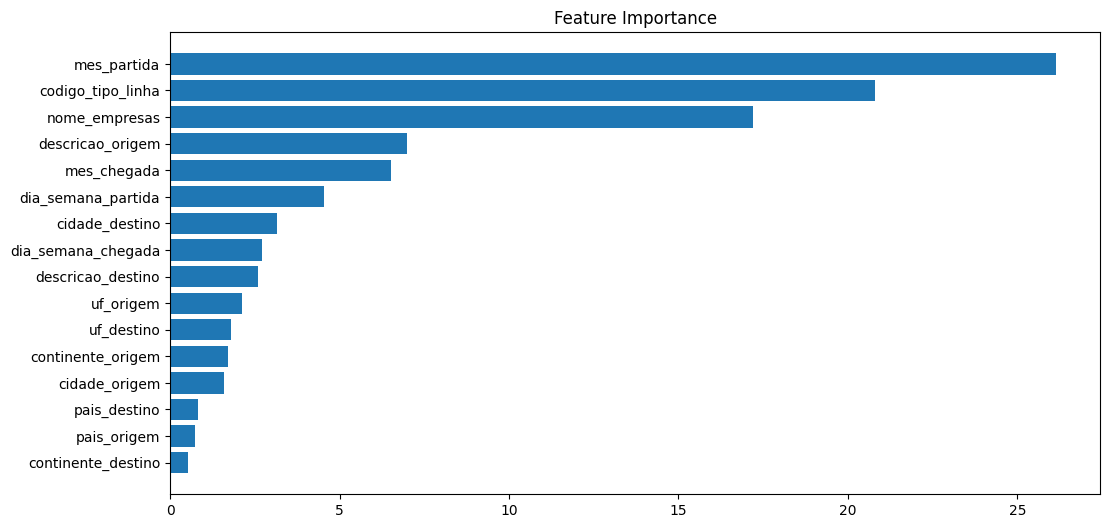

In [33]:
feature_importance = model_ctb.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

# Permutation importance

é uma técnica para determinar a importância das características em modelos de aprendizado de máquina. Ela é baseada na ideia de que a importância de uma característica pode ser medida observando-se o efeito da aleatorização<br>

Funcionamento:<br>

- Permutação de Características: Em seguida, para cada característica, você altera a ordem dos valores dessa característica no conjunto de dados (ou seja, você permuta os valores da característica).<br>

- Avaliação do Impacto: O modelo é então avaliado novamente com os dados alterados. O impacto na performance do modelo (como a acurácia, por exemplo) é medido.<br>

- Comparação com os Dados Originais: A diferença na performance do modelo entre os dados originais e os dados com a característica permutada indica a importância dessa característica. Uma grande diminuição na performance sugere que a característica é importante.<br>

É uma técnica mais robusta do que a feature importance, porém apresenta um custo computacional maior dado que acontece o processo de permutação. Em alguns casos, a permutação de características pode introduzir ruído que não reflete a realidade, especialmente em conjuntos de dados menores ou desbalanceados. Portanto ao analisarmos o resutlado temos que ter consciência que nossos dados estão desbalanceados. <br>

Neste contexto o resultado analisado será com o objetivo de corroborar com os demais resultados do processo de feature selection. <br>

## XGBoost

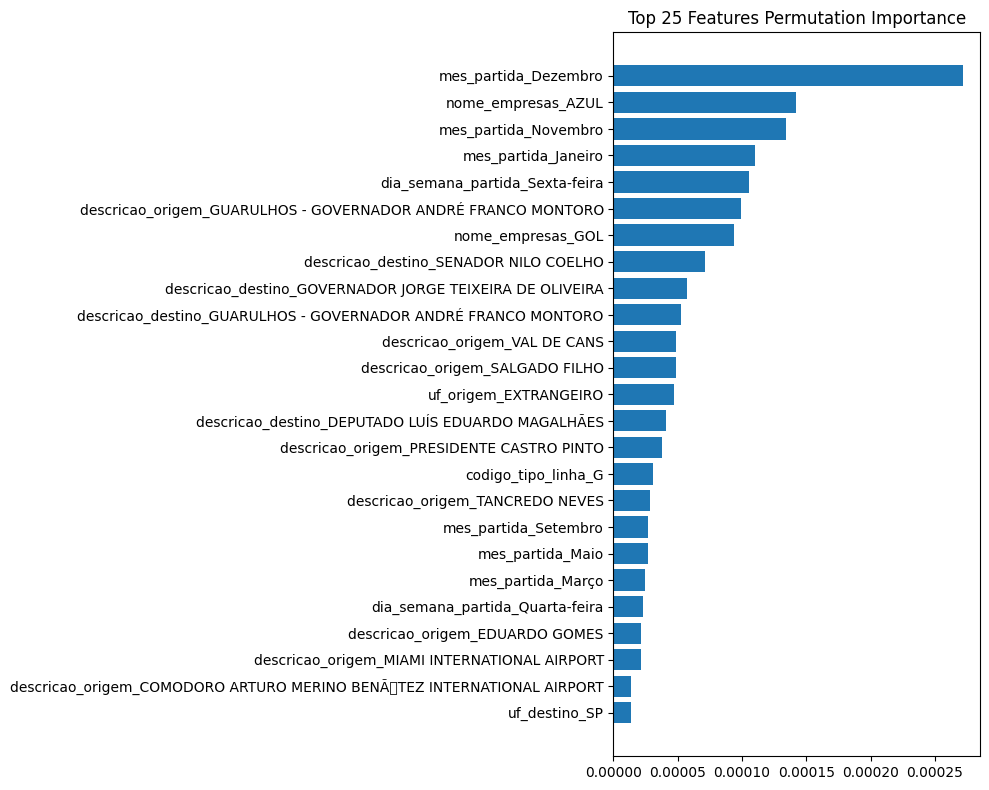

In [11]:
perm_importance = permutation_importance(model_xgb, X_test_hot, y_test_hot, n_repeats=10, random_state=123)

top_n = 25
# Ordenando as características pela importância e selecionando as top_n
sorted_idx = perm_importance.importances_mean.argsort()[-top_n:]

# Criando o gráfico de barras horizontal
plt.figure(figsize=(10, 8))  # Ajuste o tamanho conforme necessário
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')

# Definindo os y-ticks para serem os nomes das características
plt.yticks(range(len(sorted_idx)), np.array(X_test_hot.columns)[sorted_idx])

# Título do gráfico
plt.title('Top {} Features Permutation Importance'.format(top_n))

# Layout apertado para arranjo visual limpo
plt.tight_layout()

# Mostrar o gráfico
plt.show()

## CatBoost

Text(0.5, 1.0, 'Permutation Importance')

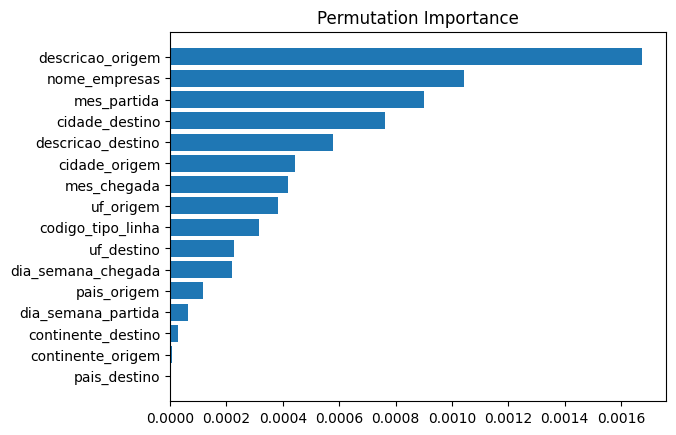

In [50]:
perm_importance = permutation_importance(model_ctb, X_test, y_test, n_repeats=10, random_state=123)
sorted_idx = perm_importance.importances_mean.argsort()
#fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance')


# Shap

SHAP (SHapley Additive exPlanations) é uma abordagem avançada para explicar as previsões de modelos de aprendizado de máquina. Baseia-se na teoria dos jogos, especificamente no conceito de valores de Shapley, para atribuir a cada característica um valor que indica a sua importância na previsão feita por um modelo. Em termos de ML, eles ajudam a determinar o quanto cada característica contribui para a previsão, considerando todas as combinações possíveis de características.<br>

Cálculo dos Valores SHAP: Para cada previsão, os valores SHAP atribuem a cada característica um valor que representa o seu impacto na mudança da previsão, em comparação com a previsão média para o dataset. Se uma característica aumenta a previsão, seu valor SHAP será positivo; se a diminui, será negativo. <br>

Em outras palavras o valor Shapley é a média (ponderada) das contribuições marginais <br>

A interpretação do valor de Shap ley é: Dado o conjunto atual de valores de recurso, a contribuição de um valor de recurso para a diferença entre a previsão real e a previsão média é o valor de Shap ley estimado.

https://github.com/shap/shap<br>
https://christophm.github.io/interpretable-ml-book/shapley.html<br>

## XGBoost

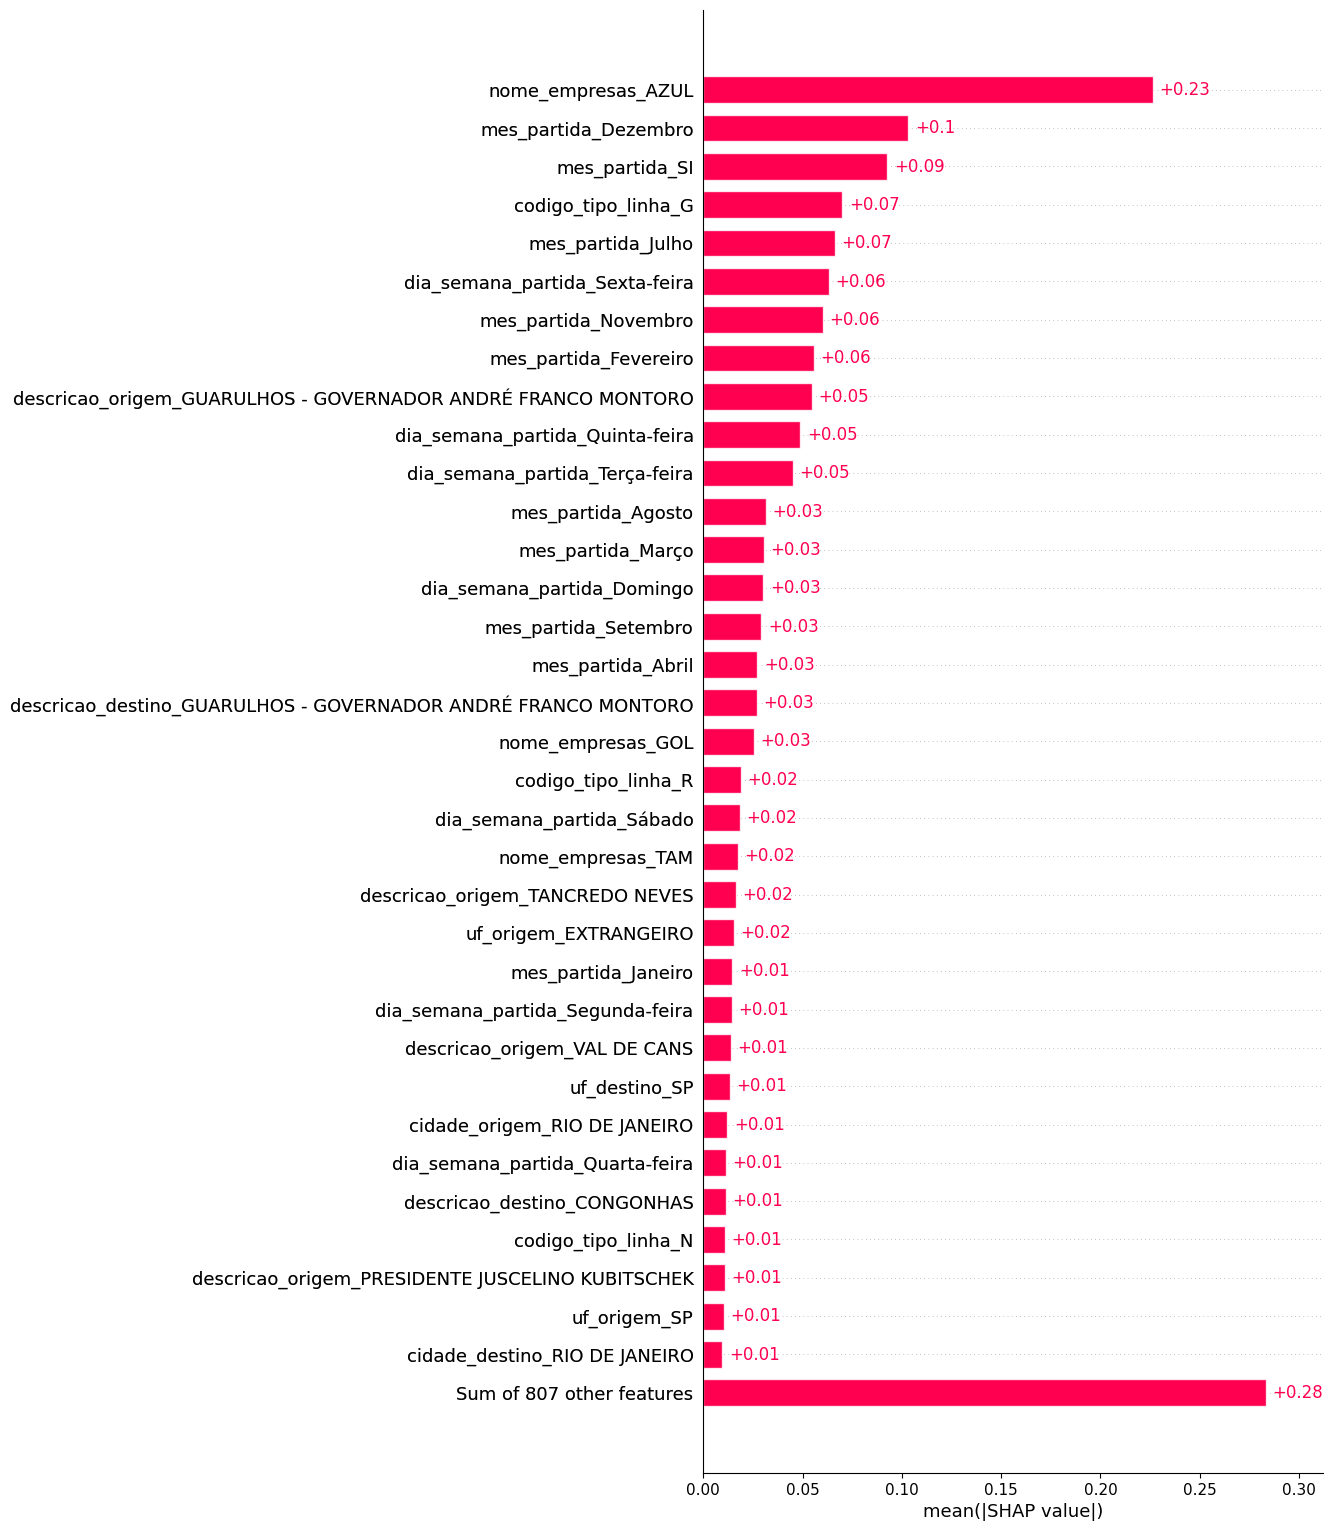

In [17]:
explainer = shap.Explainer(model_xgb)
shap_values = explainer(X_test_hot)
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
#fig = plt.figure(figsize=(22, 21))
#plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center')
#plt.yticks(range(len(sorted_idx)), np.array(X_test_hot.columns)[sorted_idx])
#plt.title('SHAP Importance')
shap.plots.bar(shap_values, max_display=35)

## CatBoost

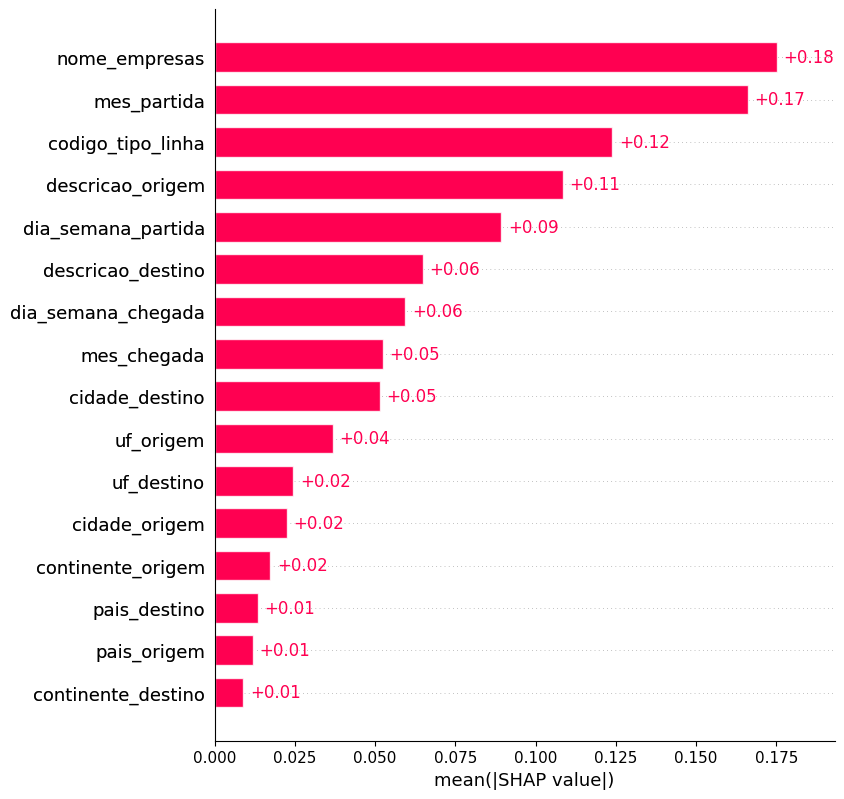

In [15]:
explainer = shap.Explainer(model_ctb)
shap_values = explainer(dt_ax)
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
fig = plt.figure(figsize=(14, 12))
shap.plots.bar(shap_values, max_display=dt_ax.shape[0])